### Python Setup

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml  #using openml to import data
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV      
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #transform different types

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

In [10]:
X.shape, y.shape

((70000, 784), (70000,))

### Data

In [3]:
X_initial, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
combine_dataset = pd.concat([X_initial, y], axis=1)
features = ['age', 'fare','embarked','sex','pclass']
X = X_initial[features].copy()
X.head()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,fare,embarked,sex,pclass
0,29.0000,211.3375,S,female,1.0
1,0.9167,151.5500,S,male,1.0
2,2.0000,151.5500,S,female,1.0
3,30.0000,151.5500,S,male,1.0
4,25.0000,151.5500,S,female,1.0


In [9]:
y

0       1
1       1
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    0
Name: survived, Length: 1309, dtype: category
Categories (2, object): ['0', '1']

In [4]:
X_initial.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,None,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


### Numerical features: applying `SimpleImputer` and `StandardScaler` into a pipeline

In [5]:
numerical_features = ['age', 'fare']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

### Categorical features: applying `SimpleImputer` and `OneHotEncoder` into another pipeline

In [7]:
categorical_features = ['embarked', 'sex', 'pclass']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

### Put everything together into the `DataTransformer` pipeline

In [8]:
data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)])

### Split the data into test and training samples

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.5,random_state=1)

### Logistic Regression Pipeline

In [12]:
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression(max_iter=10000))])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, y_train);

### Gradient Boosting Pipeline

In [13]:
pipe_gdb = Pipeline(steps=[('data_transformer', data_transformer),
       ('pipe_gdb', GradientBoostingClassifier(random_state=2))])

grid_gdb = GridSearchCV(pipe_gdb, param_grid=param_grid)
grid_gdb.fit(X_train, y_train);

### Compare the two pipelines in terms of the ROC plots

In [17]:
grid_lr.predict_proba(X_test)

array([[0.74216846, 0.25783154],
       [0.77959358, 0.22040642],
       [0.06974048, 0.93025952],
       ...,
       [0.05877651, 0.94122349],
       [0.92203709, 0.07796291],
       [0.92204881, 0.07795119]])

In [16]:
roc_auc_score(y_test, grid_lr.predict_proba(X_test)[:, 1])

0.8416321892663599

In [18]:
roc_auc_score(y_test, grid_gdb.predict_proba(X_test)[:, 1])

0.8708311481459899

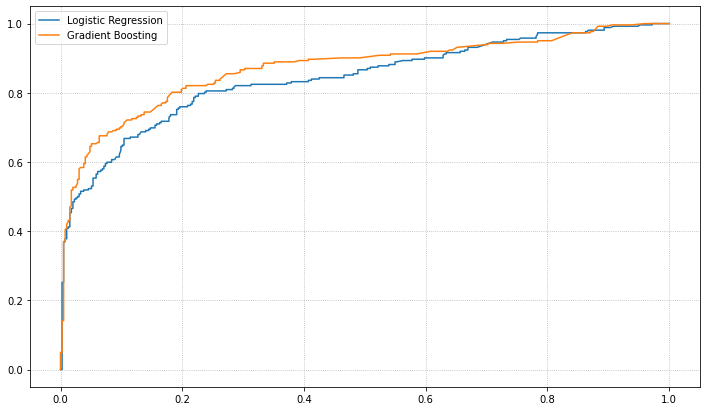

In [19]:
plt.figure(figsize=(12, 7))
fpr, tpr, thresholds = roc_curve(y_test.astype(float), grid_lr.predict_proba(X_test)[:, 1].astype(float))
plt.plot(fpr, tpr, label='Logistic Regression')
fpr, tpr, thresholds = roc_curve(y_test.astype(int), grid_gdb.predict_proba(X_test)[:, 1].astype(float))
plt.plot(fpr, tpr, label='Gradient Boosting')
plt.legend()
plt.grid(ls=":")
plt.show();